# 1st-order exact solution comparison

In this notebook, we will compare a solution of the 1st-order acoustic wave equation using an immersed boundary to the previously-used exact solution.

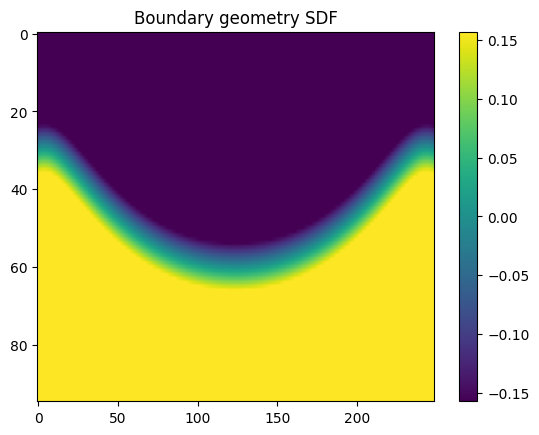

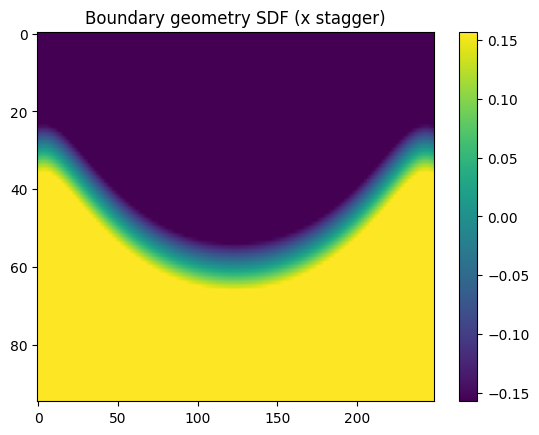

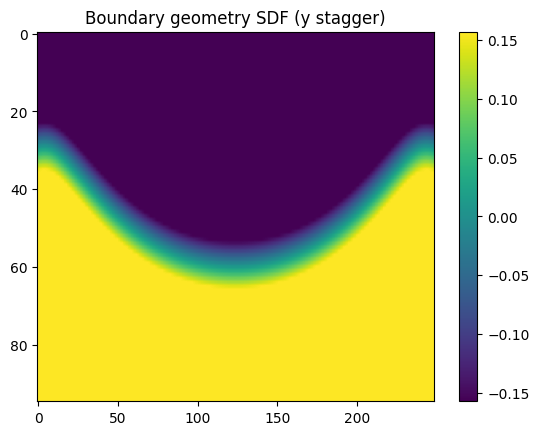

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import numpy as np
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = 'sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the unstaggered sdf for the exact solution
sdf = read_sdf('exact_solution_surface_periodic_base_pad_1.0', 2)
# Load the staggered sdfs
sdf_x = read_sdf('exact_solution_surface_periodic_base_pad_x_1.0', 2)
sdf_y = read_sdf('exact_solution_surface_periodic_base_pad_y_1.0', 2)

plt.imshow(sdf.data.T, aspect='auto')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

plt.imshow(sdf_x.data.T, aspect='auto')
plt.title("Boundary geometry SDF (x stagger)")
plt.colorbar()
plt.show()

plt.imshow(sdf_y.data.T, aspect='auto')
plt.title("Boundary geometry SDF (y stagger)")
plt.colorbar()
plt.show()

In [2]:
# Set up the exact solution

# Use SDF grid
grid = sdf.grid

# Misc parameters
c0 = 1
m = 8
A = 0.25
rho = 1

# Functions required
def x1(x, y, A):
    return x - A*np.sin(x)*np.cosh(y)

def y1(x, y, A):
    return y - A*np.cos(x)*np.sinh(y)

def f1(x, y, A):
    return 1 - A*np.cos(x)*np.cosh(y)

def f2(x, y, A):
    return A*np.sin(x)*np.sinh(y)

def c(x, y, A, c0):
    term1 = (1-A*np.cos(x)*np.cosh(y))**2
    term2 = (A*np.sin(x)*np.sinh(y))**2
    return c0*(term1 + term2)**-0.5

def alpha(m, c0):
    return c0*np.sqrt(m**2+(np.pi/2)**2)

def u(t, x, y, c0, m, A):
    x1_vals = x1(x, y, A)
    y1_vals = y1(x, y, A)
    alp = alpha(m, c0)
    return np.cos(m*x1_vals-alp*t)*np.cos(np.pi*y1_vals/2)

def u2(t, x, y, c0, m, A):
    x1_vals = x1(x, y, A)
    y1_vals = y1(x, y, A)
    alp = alpha(m, c0)
    return np.sin(m*x1_vals-alp*t)*np.sin(np.pi*y1_vals/2)

def vx(t, x, y, c0, m, A):
    f1_vals = f1(x, y, A)
    f2_vals = f2(x, y, A)
    u_vals = u(t, x, y, c0, m, A)
    u2_vals = u2(t, x, y, c0, m, A)
    alp = alpha(m, c0)
    term1 = -m*f1_vals*u_vals
    term2 = np.pi*f2_vals*u2_vals/2
    return (term1 + term2)/alp

def vy(t, x, y, c0, m, A):
    f1_vals = f1(x, y, A)
    f2_vals = f2(x, y, A)
    u_vals = u(t, x, y, c0, m, A)
    u2_vals = u2(t, x, y, c0, m, A)
    alp = alpha(m, c0)
    term1 = m*f2_vals*u_vals
    term2 = np.pi*f1_vals*u2_vals/2
    return (term1 + term2)/alp

xvals = np.linspace(0, 2*np.pi, grid.shape[0]-8)  # Trim off the edges where we will have bcs
yvals = np.linspace(-3*np.pi/4, 0, grid.shape[1]-4)  # -3pi/4

xmsh, ymsh = np.meshgrid(xvals, yvals, indexing='ij')

In [3]:
# Need to set up the subdomains
import devito as dv


# Note that we are leaving a 4 point pad on each side to ensure stencils generate correctly
class MainDomain(dv.SubDomain):  # Main section of the grid
    name = 'main'
    def __init__(self):
        super().__init__()            

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', 4, 4), y: ('middle', 0, 4)}

    
main_domain = MainDomain()

new_grid = dv.Grid(shape=grid.shape, extent=grid.extent, origin=grid.origin, dimensions=grid.dimensions,
                   subdomains=[main_domain])

print(new_grid.shape)
print(new_grid.spacing)

(249, 95)
(0.02617994, 0.02617994)


In [4]:
import sympy as sp
from schism import BoundaryGeometry

# Rebuild the SDF on the new grid so we can use these subdomains
x, y = new_grid.dimensions
h_x = x.spacing
h_y = y.spacing
zero = sp.core.numbers.Zero()

new_sdf = dv.Function(name='sdf', grid=new_grid, space_order=sdf.space_order)
new_sdf.data[:] = sdf.data[:]

new_sdf_x = dv.Function(name='sdf_x', grid=new_grid, space_order=sdf_x.space_order,
                        staggered=x)
new_sdf_x.data[:] = sdf_x.data[:]

new_sdf_y = dv.Function(name='sdf_y', grid=new_grid, space_order=sdf_y.space_order,
                        staggered=y)
new_sdf_y.data[:] = sdf_y.data[:]

cutoff = {(h_x/2, zero): 0., (zero, h_y/2): 0.}

bg = BoundaryGeometry((new_sdf, new_sdf_x, new_sdf_y), cutoff=cutoff)

Operator `normals` ran in 0.01 s


In [5]:
interior_mask = bg.interior_mask[(zero, zero)][4:-4, :-4]
interior_mask_x = bg.interior_mask[(h_x/2, zero)][4:-4, :-4]
interior_mask_y = bg.interior_mask[(zero, h_y/2)][4:-4, :-4]

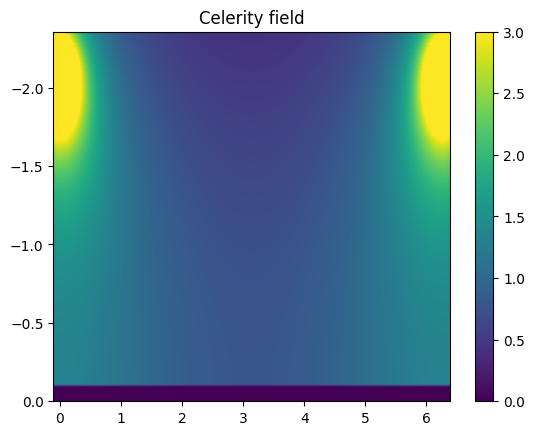

In [6]:
# Set up the celerity field
cel = dv.Function(name='vel', grid=new_grid)
# Cap the velocity at 3, as these points are outside the domain anyway
cel_data = np.minimum(c(xmsh, ymsh, A, c0), 3)
# Add the edges
cel_data_full = np.concatenate((cel_data[-5:-1], cel_data, cel_data[1:5]))
cel.data[:, :-4] = cel_data_full[:]

plt.imshow(cel.data.T, extent=(-4*grid.spacing[0], 2*np.pi+4*grid.spacing[0], 0, -3*np.pi/4), aspect='auto')
plt.title("Celerity field")
plt.colorbar()
plt.show()

In [7]:
# Set the timestep at 10% of critical timestep
dt = 0.1*new_grid.spacing[0]/np.amax(cel.data)

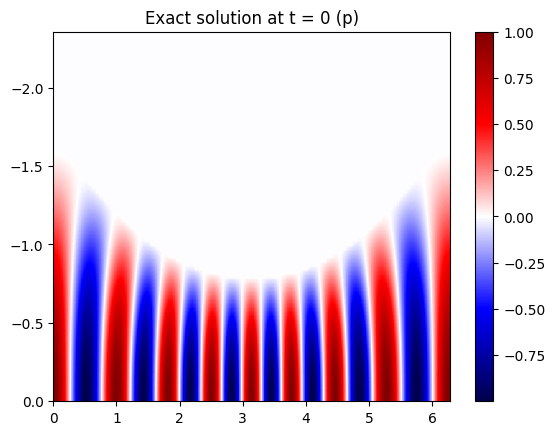

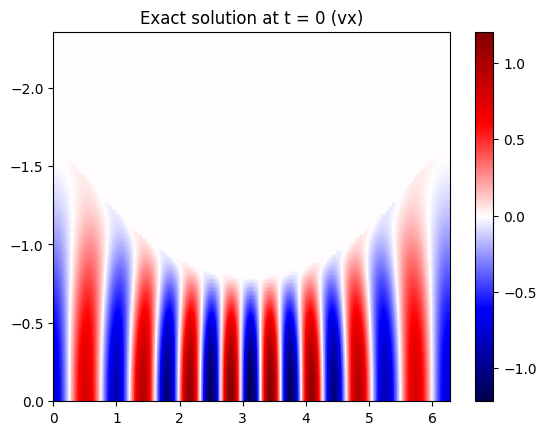

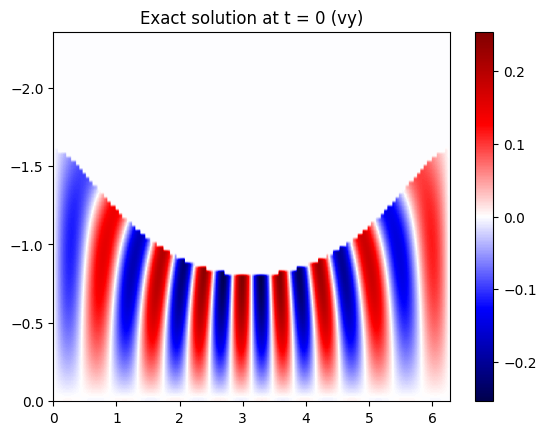

In [8]:
# Plot the solution masked with the interior mask
import sympy as sp

u0 = u(0, xmsh, ymsh, c0, m, A)
vx0 = vx(-dt/2, xmsh+new_grid.spacing[0]/2, ymsh, c0, m, A)
vy0 = vy(-dt/2, xmsh, ymsh+new_grid.spacing[1]/2, c0, m, A)

u0[np.logical_not(interior_mask)] = 0
vx0[np.logical_not(interior_mask_x)] = 0
vy0[np.logical_not(interior_mask_y)] = 0

plt.imshow(u0.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact solution at t = 0 (p)")
plt.colorbar()
plt.show()

plt.imshow(vx0.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact solution at t = 0 (vx)")
plt.colorbar()
plt.show()

plt.imshow(vy0.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact solution at t = 0 (vy)")
plt.colorbar()
plt.show()

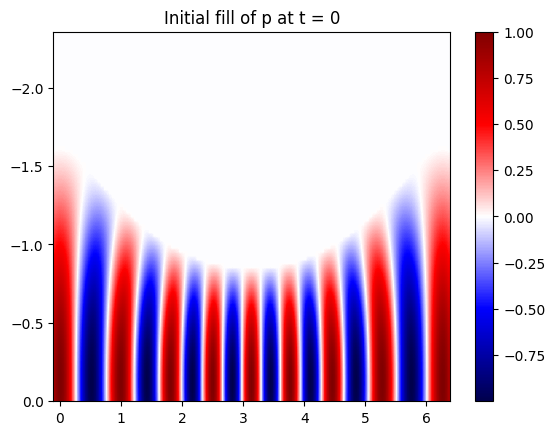

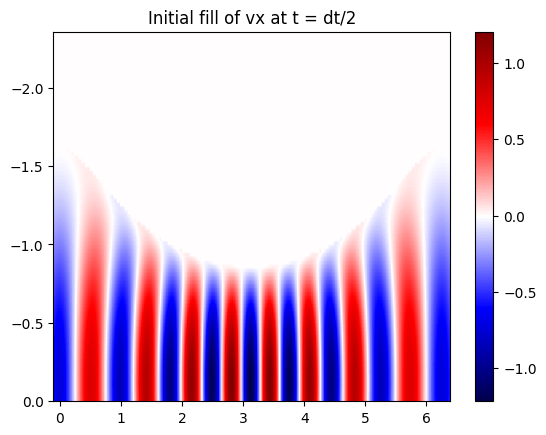

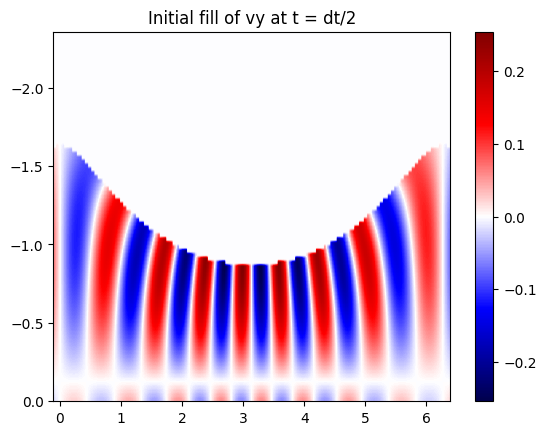

In [9]:
# Set up the TimeFunctions
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=new_grid, space_order=s_o,
                    time_order=1, staggered=dv.NODE)
v = dv.VectorTimeFunction(name='v', grid=new_grid, space_order=s_o,
                          time_order=1)

# Initialise the zero timestep for pressure
p.data[:, :, :-4] = np.concatenate((u0[-5:-1], u0, u0[1:5]))
p.data[:, :, -4:] = p.data[:, :, -6:-10:-1]  # Mirror below the zero flux bc

# Initialise the dt/2 timestep for vx
v[0].data[:, :, :-4] = np.concatenate((vx0[-5:-1], vx0, vx0[1:5]))
v[0].data[:, :, -4:] = v[0].data[:, :, -6:-10:-1]  # Mirror below the zero flux bc

# Initialise the dt/2 timestep for vy
v[1].data[:, :, :-5] = np.concatenate((vy0[-5:-1], vy0, vy0[1:5]))
# Antisymmetric around pressure node
v[1].data[:, :, -5:] = -v[1].data[:, :, -6:-11:-1]  # Mirror below the zero flux bc

plt.imshow(p.data[0].T, extent=(-4*grid.spacing[0], 2*np.pi+4*grid.spacing[0], 0, -3*np.pi/4),
                                aspect='auto', cmap='seismic')
plt.title("Initial fill of p at t = 0")
plt.colorbar()
plt.show()

plt.imshow(v[0].data[0].T, extent=(-4*grid.spacing[0], 2*np.pi+4*grid.spacing[0], 0, -3*np.pi/4),
                                aspect='auto', cmap='seismic')
plt.title("Initial fill of vx at t = dt/2")
plt.colorbar()
plt.show()

plt.imshow(v[1].data[0].T, extent=(-4*grid.spacing[0], 2*np.pi+4*grid.spacing[0], 0, -3*np.pi/4),
                                aspect='auto', cmap='seismic')
plt.title("Initial fill of vy at t = dt/2")
plt.colorbar()
plt.show()

In [10]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),  # Zero pressure on free surface
           dv.Eq(p.dx2 + p.dy2, 0),  # Zero laplacian
           dv.Eq(p.dx4 + 2*p.dx2dy2 + p.dy4, 0),  # Zero biharmonic
           dv.Eq(v[0].dx + v[1].dy, 0),  # Divergence of velocity equals zero
           dv.Eq(v[0].dx3 + v[1].dx2dy
                 + v[0].dxdy2 + v[1].dy3, 0)]  # Laplacian of divergence is zero

bcs = BoundaryConditions(bc_list)

In [11]:
from schism import Boundary

boundary = Boundary(bcs, bg)

In [12]:
# Shorthands for derivatives
pdx = p.dx(x0=x+x.spacing/2)
pdy = p.dy(x0=y+y.spacing/2)
vxdx = v[0].forward.dx(x0=x)
vydy = v[1].forward.dy(x0=y)

derivs = (pdx, pdy, vxdx, vydy)

subs = boundary.substitutions(derivs)

Generating stencils for Derivative(p(t, x, y), x)
Generating stencils for Derivative(p(t, x, y), y)
Generating stencils for Derivative(v_x(t + dt, x + h_x/2, y), x)
Support expanded. Remaining =  123
Support expanded. Remaining =  12
Generating stencils for Derivative(v_y(t + dt, x, y + h_y/2), y)
Support expanded. Remaining =  300
Support expanded. Remaining =  24


In [13]:
rho = 1

# Pressure update
eq_p = dv.Eq(p.forward, p + dt*rho*cel**2*(subs[vxdx] + subs[vydy]), subdomain=main_domain)
# Velocity updates
eq_vx = dv.Eq(v[0].forward, v[0] + dt*subs[pdx]/rho, subdomain=main_domain)
eq_vy = dv.Eq(v[1].forward, v[1] + dt*subs[pdy]/rho, subdomain=main_domain)

In [14]:
# Set up periodic BCs
t = new_grid.stepping_dim

x, y = new_grid.dimensions

left_bcs_p = [dv.Eq(p[t+1, i, y], p[t+1, new_grid.shape[0]-9+i, y])
              for i in range(4)]
right_bcs_p = [dv.Eq(p[t+1, new_grid.shape[0]-5+i, y], p[t+1, i+4, y])
               for i in range(5)]
left_bcs_vx = [dv.Eq(v[0][t+1, i, y], v[0][t+1, new_grid.shape[0]-9+i, y])
               for i in range(4)]
right_bcs_vx = [dv.Eq(v[0][t+1, new_grid.shape[0]-5+i, y], v[0][t+1, i+4, y])
                for i in range(5)]
left_bcs_vy = [dv.Eq(v[1][t+1, i, y], v[1][t+1, new_grid.shape[0]-9+i, y])
               for i in range(4)]
right_bcs_vy = [dv.Eq(v[1][t+1, new_grid.shape[0]-5+i, y], v[1][t+1, i+4, y])
                for i in range(5)]

periodic_bcs_p = left_bcs_p + right_bcs_p
periodic_bcs_vx = left_bcs_vx + right_bcs_vx
periodic_bcs_vy = left_bcs_vy + right_bcs_vy

In [15]:
# Set up zero-flux bc
ymax = new_grid.shape[1] - 1  # Max y index
# Mirror pressure around index 4 (5->3, 6->2, 7->1, 8->0)
zero_flux_p = [dv.Eq(p[t+1, x, ymax-3+i], p[t+1, x, ymax-5-i])
               for i in range(4)]
# Mirror vx around index 4
zero_flux_vx = [dv.Eq(v[0][t+1, x, ymax-3+i], v[0][t+1, x, ymax-5-i])
                for i in range(4)]
# Mirror vy around index 4.5 (5->4, 6->3, 7->2, 8->1, 9->0)
zero_flux_vy = [dv.Eq(v[1][t+1, x, ymax-4+i], -v[1][t+1, x, ymax-5-i])
                for i in range(5)]

In [16]:
# Set up number of timesteps
t_max = 2*np.pi/c0

print(float(t_max/dt))
nsteps = int(round(float(t_max/dt)))
print(nsteps)

7199.999799641752
7200


In [17]:
op = dv.Operator([eq_vx, eq_vy] + periodic_bcs_vx + periodic_bcs_vy
                 + zero_flux_vx + zero_flux_vy
                 + [eq_p] + periodic_bcs_p + zero_flux_p)

In [18]:
op.apply(dt=dt, t_M=nsteps)

Operator `Kernel` ran in 86.33 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=10.052069999999967, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.021199999999998883, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=76.1822969999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.013786999999999834, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=0.04537799999999799, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

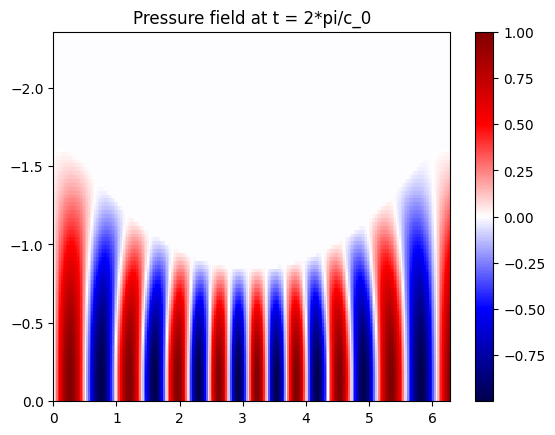

In [19]:
# Remember to trim edges where periodic bcs are applied
# Index in the buffer where the final timestep should be stored:
ind = (nsteps) % 2
plt.imshow(p.data[ind].T, extent=(0, 2*np.pi, 0, -3*np.pi/4),
           aspect='auto', cmap='seismic', interpolation='none')
plt.title("Pressure field at t = 2*pi/c_0")
plt.colorbar()
plt.show()

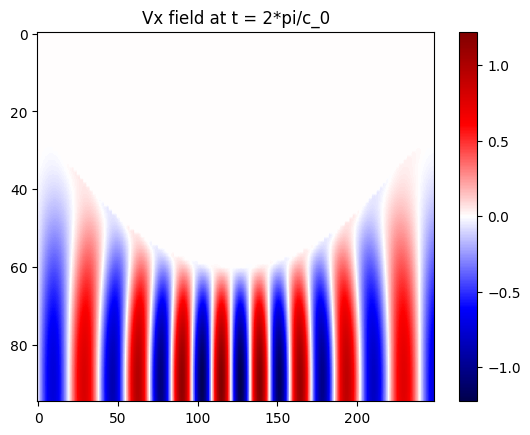

In [20]:
plt.imshow(v[0].data[ind].T, aspect='auto', cmap='seismic')
plt.title("Vx field at t = 2*pi/c_0")
plt.colorbar()
plt.show()

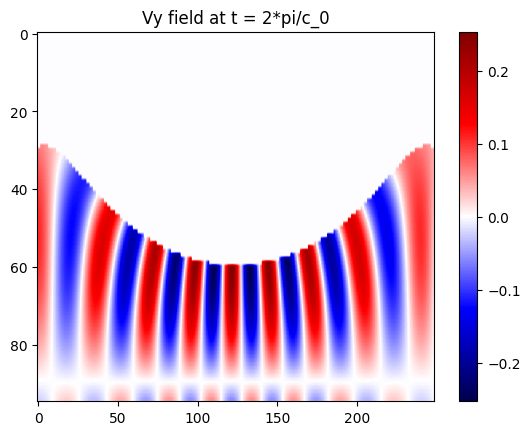

In [21]:
plt.imshow(v[1].data[ind].T, aspect='auto', cmap='seismic')
plt.title("Vy field at t = 2*pi/c_0")
plt.colorbar()
plt.show()

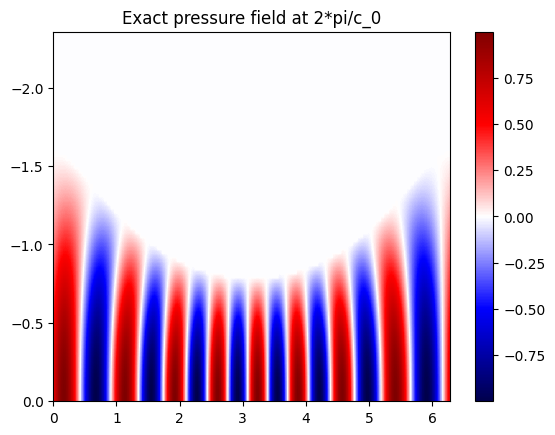

0 0.0031714973803647906


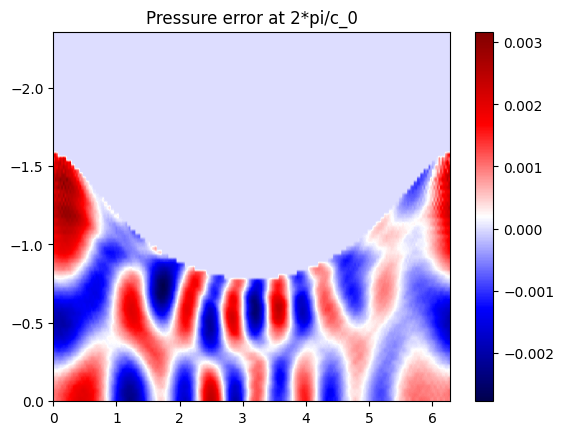

In [22]:
uend = u(t_max, xmsh, ymsh, c0, m, A)
uend[np.logical_not(interior_mask)] = 0
plt.imshow(uend.T,
           extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact pressure field at 2*pi/c_0")
plt.colorbar()
plt.show()

print(ind, np.amax(np.abs(p.data[ind, 4:-4, :-4].T-uend.T)))

plt.imshow(p.data[ind, 4:-4, :-4].T-uend.T,
           extent=(0, 2*np.pi, 0, -3*np.pi/4),
           aspect='auto', cmap='seismic')
plt.title("Pressure error at 2*pi/c_0")
plt.colorbar()
plt.show()

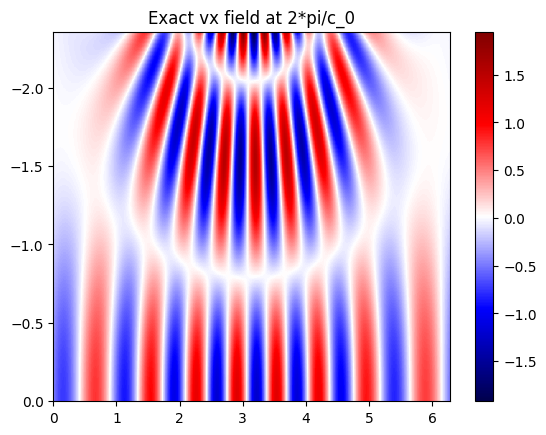

In [23]:
plt.imshow(vx(t_max + dt/2, xmsh+new_grid.spacing[0]/2, ymsh, c0, m, A).T,
              extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact vx field at 2*pi/c_0")
plt.colorbar()
plt.show()

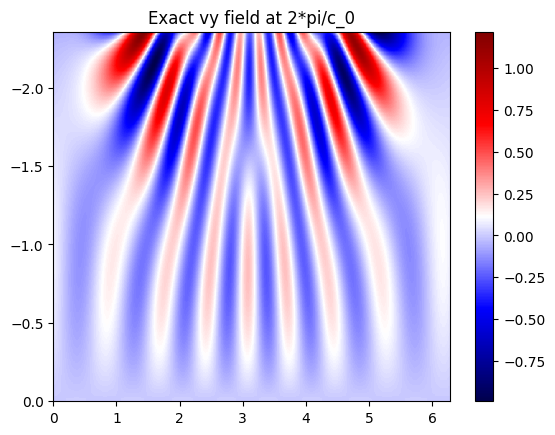

In [24]:
plt.imshow(vy(t_max + dt/2, xmsh, ymsh+new_grid.spacing[1]/2, c0, m, A).T,
              extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact vy field at 2*pi/c_0")
plt.colorbar()
plt.show()